In [1]:
import nll
import numpy as np
import utils
from matplotlib import pyplot as plt
import dataset_sines_infinite
import dataset_sines_finite
import dataset_step_infinite
import scipy
from scipy.special import gamma, kv

In [2]:
seed = 2
np.random.seed(seed)
print(seed)

2


In [68]:
def gaussian_posterior_full(kernel_matrix, x_a, y_a, x_b, maddox_noise):
    """
    Computes the gaussian posterior with this kernel and this data, on the queried inputs.
    x_a is a (batch_size, input_dims) array (! has lost n_tasks)
    y_a is a (batch_size, reg_dim) array (! has lost n_tasks)
    Returns the posterior covariance matrix
    """
    y_a = np.reshape(y_a, (-1,))

    cov_a_a = kernel_matrix(x_a, x_a)
    cov_a_a = cov_a_a + maddox_noise ** 2 * np.eye(cov_a_a.shape[0])
    cov_b_a = kernel_matrix(x_b, x_a)
    cov_b_b = kernel_matrix(x_b, x_b)

    print(np.linalg.det(cov_a_a))
    L = scipy.linalg.cho_factor(cov_a_a)
    alpha = scipy.linalg.cho_solve(L, y_a)
    post_mean = cov_b_a @ alpha
    
    v = scipy.linalg.cho_solve(L, cov_b_a.T)
    post_cov = cov_b_b - cov_b_a @ v
    
    return post_mean, post_cov

In [69]:
def plot_gpr(x_a_all, y_a_all, x_b, y_b, kernel_matrix, K, dataset_provider):
    """
    Make an informative prediction plot in the singGP case (for the kernel specified)
    K is the number of context inputs
    Change dataset_provider to test on other datasets (e.g. dataset_sines_infinite)
    """
    y_min, y_max = np.min(y_b) - 0.5, np.max(y_b) + 0.5

    x_a = x_a_all[:K]
    y_a = y_a_all[:K]
    prediction, cov = gaussian_posterior_full(kernel_matrix, x_a, y_a, x_b, 0.05)

    error = dataset_provider.error_fn(prediction, y_b)
    loss = nll.nll(kernel_self_matrix, x_a, y_a, maddox_noise=0.05)

    variances = np.diag(cov)
    stds = np.sqrt(variances)

    plt.plot(x_b, y_b, "g--", label="Target")
    plt.plot(x_a, y_a, "ro", label="Context data")
    plt.plot(x_b, prediction, "b", label="Prediction")
    plt.fill_between(x_b, prediction - 1.96 * stds, prediction + 1.96 * stds, color='blue', alpha=0.1, label="+/- 1.96$\sigma$")
    plt.title(f"NLL={loss:.4f}, MSE={error:.4f} ($K$={K})")
    plt.legend()
    plt.gca().set_ylim([np.min(prediction), np.max(prediction)])
    plt.gca().set_xlabel("$x$")
    plt.gca().set_ylabel("$y$")
    plt.legend()

## Choice of kernels : 

In [70]:
l = 1

def RBF_kernel(x1, x2):
    # Now x1 and x2 are compatible for broadcasting
    # Compute squared Euclidean distance
    squared_diff = (x1 - x2) ** 2 / (2*l**2)
    return np.exp(-np.sum((x1 - x2)**2))

In [71]:
def CosSim_kernel(x1, x2):
    normalized_factor = np.linalg.norm(x1)*np.linalg.norm(x2)
    return np.dot(x1, x2)

In [72]:
p = 2
c = 1

def polynomial_kernel(x1, x2):
    return (np.dot(x1, x2) + c)**p

In [73]:
length_scale = 1
nu = 2.5
sigma = 1

def matern_kernel(x1, x2):
    """
    Compute the Matérn kernel between points in x.

    Parameters:
    - x: array-like of shape (n_samples, n_features)
    - length_scale: the length scale of the kernel.
    - nu: smoothness parameter.
    - sigma: variance parameter.

    Returns:
    - Kernel matrix of shape (n_samples, n_samples).
    """
    # Compute pairwise Euclidean distances
    pairwise_sq_dists = np.sum((x1 - x2)**2)
    # Scale the distances by the length scale
    sqrt_2_nu_d = np.sqrt(2 * nu * pairwise_sq_dists) / length_scale
    # Compute the kernel
    kernel = (sigma**2) * (2**(1-nu) / gamma(nu)) * (sqrt_2_nu_d**nu) * kv(nu, sqrt_2_nu_d)
    # Handle zero distances (diagonal should be 1)
    return kernel


In [82]:
Q = 4
weights = np.array([1, 1, 1, 1])
means = np.array([1, 1, 1, 1])
variances = np.array([1, 1, 1, 1])

def spectral_mixture_kernel(x1, x2):
    """
    Compute the Spectral Mixture (SM) kernel between arrays x and xp.

    Parameters:
    - x, xp: Arrays of shape (n_samples, 1) or similar (input points for the kernel).
    - weights: Array of shape (Q,) where Q is the number of mixture components (mixture weights).
    - means: Array of shape (Q,) (mean frequencies of the components).
    - variances: Array of shape (Q,) (variances of the components).
    - Q: int, number of spectral mixture components.

    Returns:
    - Kernel matrix of shape (n_samples_x, n_samples_xp).
    """
    # Reshape to make broadcasting work correctly
    # x = x[:, np.newaxis]  # Shape (n_samples_x, 1, 1)
    # xp = xp[np.newaxis, :]  # Shape (1, n_samples_xp, 1)
    
    # Difference matrix
    # r = x - xp  # Shape (n_samples_x, n_samples_xp, 1)
    
    # Initialize the kernel matrix
    # kernel = np.zeros((x.shape[0], xp.shape[1]))
    
    # Sum over all mixture components
    kernel = 0
    for q in range(Q):
        # Squared exponential decay term
        exp_decay = np.exp(-2 * np.pi**2 * variances[q] * np.sum((x1 - x2)**2))
        
        # Cosine term
        cos_term = np.cos(2 * np.pi * means[q] * np.sqrt(np.sum((x1 - x2)**2)))
        
        # Combine terms and add to the kernel matrix
        kernel += weights[q] * exp_decay * cos_term
    
    return kernel

In [83]:
#Choose here: 
kernel = spectral_mixture_kernel
vectorized_kernel = np.vectorize(kernel)

def kernel_matrix(x1, x2):
    matrix = vectorized_kernel(x1[:, np.newaxis], x2[np.newaxis, :])
    # For matern_kernel
    # matrix[np.isnan(matrix)] = sigma**2
    return matrix

def kernel_self_matrix(x1):
    matrix = vectorized_kernel(x1[:, np.newaxis], x1[np.newaxis, :])
    # For matern_kernel
    # matrix[np.isnan(matrix)] = sigma**2
    return matrix

x = np.array([1, 2, 3])  # Vector of length k
y = np.array([1, 2, 3, 4])  # Vector of length l.

print(kernel_matrix(x, x))
print()
print(kernel_matrix(x, x))

[[4.00000000e+00 1.07011520e-08 2.04900091e-34]
 [1.07011520e-08 4.00000000e+00 1.07011520e-08]
 [2.04900091e-34 1.07011520e-08 4.00000000e+00]]

[[4.00000000e+00 1.07011520e-08 2.04900091e-34]
 [1.07011520e-08 4.00000000e+00 1.07011520e-08]
 [2.04900091e-34 1.07011520e-08 4.00000000e+00]]


## Get batch

In [84]:
def get_fancy_test_batch(K, L, data_noise):
    reg_dim = 1

    function = draw_multi(reg_dim)
    
    x = np.random.uniform(low=-5, high=5, size=(K+L, 1))
    y = function(x)
    noise = np.random.normal(size=(K, reg_dim)) * data_noise
    y[:K, :] = function(x[:K]) + noise
    y[K:, :] = function(x[K:])

    return x, y, function


def draw_multi(reg_dim, amp_low=0.1, amp_high=5, phase_low=0, phase_high=np.pi):

    amps = np.random.uniform(low=amp_low, high=amp_high, size=(reg_dim,))
    phases = np.random.uniform(low=amp_low, high=amp_high, size=(reg_dim,))
    
    def function(x):
        return amps * np.sin(x + phases) + 1
        
    return function

# x, y, fun = get_fancy_test_batch(50, 0, 0.05)
# x_fun = np.linspace(-5, 5, 100)
# plt.plot(x, y, "ro")
# plt.plot(x_fun, fun(x_fun))

3190.4480680242136


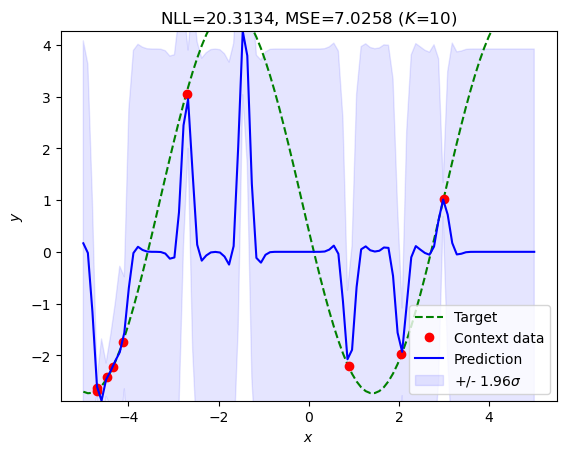

In [85]:
K = 10
x, y, fun = get_fancy_test_batch(K=K, L=0, data_noise=0.05)

x_a_all = x[:K]
y_a_all = y[:K]
x_a_all = np.reshape(x_a_all, (-1,))
y_a_all = np.reshape(y_a_all, (-1,))
# print(x_a_all.shape, y_a_all.shape)

x_b = np.linspace(-5, 5, 100)[:, np.newaxis]
y_b = fun(x_b)
x_b = np.reshape(x_b, (-1,))
y_b = np.reshape(y_b, (-1,))
# print(x_b.shape, y_b.shape)

plot_gpr(x_a_all, y_a_all, x_b, y_b, kernel_matrix, K, dataset_sines_infinite)